In [60]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks'

#Preprocessing

In [47]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionResNetV2 as resnet
from keras.preprocessing.image import ImageDataGenerator

In [72]:
#read in training labels
df = pd.read_csv("cassava-leaf-disease-classification/train_1.csv")
df['label'] = df['label'].astype(str)
df


,image_id,label
0,2615227158.jpg,4
1,1277648239.jpg,3
2,2305895487.jpg,3
3,336299725.jpg,2
4,1951270318.jpg,2
...,...,...
17112,318991539.jpg,3
17113,1180914426.jpg,3
17114,3601015067.jpg,2
17115,3037445022.jpg,3


In [73]:
training_images = 'cassava-leaf-disease-classification/train_imgs_1/'

#generator to generate augmented images to increase the amount of data passed to train model
data_generator = ImageDataGenerator(
    rescale = 1./255,   #scale in between 0 and 1
    validation_split = 0.20,  #validation data is 2/10 of augmented data
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = (0.6, 1.4),
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

#iterator to control the flow of training data intol the model
print('the training set loader.')
train_data_loader = data_generator.flow_from_dataframe(
    df,
    directory = training_images,
    x_col = "image_id",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 64, 
    subset = 'training'
)

#iterator to control the flow of validation data into the model
print('the validation set loader.')
val_data_loader = data_generator.flow_from_dataframe(
    df,
    directory = training_images,
    x_col = "image_id",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 64, 
    subset = 'validation'
)

/content/drive/My Drive/Colab Notebooks
the training set loader.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6903 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 8172 validated image filenames belonging to 5 classes.
the validation set loader.
Found 2042 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6903 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


#Model

In [51]:
#Using Keras Functional API to build model from RESNET152V2
#create the base model using ResNet model
base = resnet(
    include_top = False,
    weights = "imagenet",
    input_shape = (224,224,3),
)
#lock weights
base.trainable = False;

#build model
input = keras.Input(shape=(224, 224, 3))
output = base(input, training = False)
output = keras.layers.GlobalAveragePooling2D()(output)

#add first, second, third, and final output layers
layer1_output = keras.layers.Dense(100, activation = 'selu')(output)
layer2_output = keras.layers.Dense(50, activation = 'selu')(layer1_output)
layer3_output = keras.layers.Dense(10, activation = 'selu')(layer2_output)
final_output = keras.layers.Dense(5, activation = 'softmax')(layer3_output)

#join layers
model = keras.Model(input, final_output)

#build model with selected parameters
model.compile(optimizer=keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
#show model
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_9   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_36 (Dense)            (None, 100)               153700    
                                                                 
 dense_37 (Dense)            (None, 50)                5050      
                                                                 
 dense_38 (Dense)            (None, 10)                510

#Model Training

In [52]:
#train the model with batches of 64 samples (in generator code) using 10 epochs (iterations of whole dataset)
history = model.fit(x = train_data_loader,
                    validation_data = val_data_loader,
                    epochs = 10)
                    #callbacks = [model_checkpoint_callback])

Epoch 1/10
128/128 [==============================] - 239s 2s/step - loss: 1.0668 - accuracy: 0.6374 - val_loss: 1.0278 - val_accuracy: 0.6342
Epoch 2/10
128/128 [==============================] - 219s 2s/step - loss: 0.9223 - accuracy: 0.6637 - val_loss: 0.9644 - val_accuracy: 0.6503
Epoch 3/10
128/128 [==============================] - 219s 2s/step - loss: 0.9079 - accuracy: 0.6721 - val_loss: 0.9167 - val_accuracy: 0.6665
Epoch 4/10
128/128 [==============================] - 219s 2s/step - loss: 0.8836 - accuracy: 0.6776 - val_loss: 0.9061 - val_accuracy: 0.6738
Epoch 5/10
128/128 [==============================] - 216s 2s/step - loss: 0.8920 - accuracy: 0.6735 - val_loss: 0.9336 - val_accuracy: 0.6499
Epoch 6/10
128/128 [==============================] - 212s 2s/step - loss: 0.8618 - accuracy: 0.6904 - val_loss: 0.9336 - val_accuracy: 0.6724
Epoch 7/10
128/128 [==============================] - 215s 2s/step - loss: 0.8561 - accuracy: 0.6900 - val_loss: 0.8843 - val_accuracy: 0.6763

#Model Performance

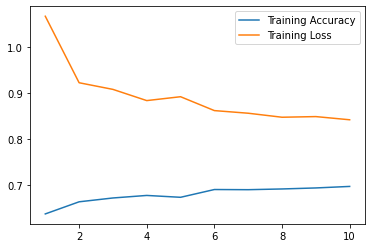

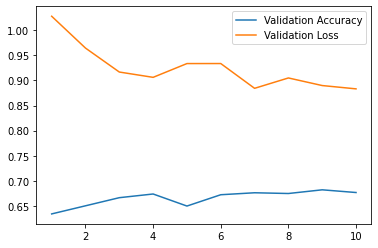

In [91]:
#Training Accuracy/Loss Plot
x = list(range(1, len(history.history['accuracy'])+1))
plt.plot(x, history.history['accuracy'], label = 'Training Accuracy')
plt.plot(x, history.history['loss'], label = 'Training Loss')
plt.legend()
plt.show()

#Validation Accuracy/Loss Plot
x = list(range(1, len(history.history['val_accuracy'])+1))
plt.plot(x, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.plot(x, history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

#Model Testing for Submission

In [94]:
testing_images = 'cassava-leaf-disease-classification/test_imgs_1/'

#dataframe to store image id. Will be used for submission
test_df = os.listdir(testing_images)
print(test_df)
test_df = pd.DataFrame(test_df, columns=['image_id'])

#data generator to load images into model using batches of 64 images
test_data_generator = ImageDataGenerator()
test_data_loader = test_data_generator.flow_from_dataframe(
    test_df,
    testing_images,     #testing dataset without class labels
    target_size = (224, 224),
    color_mode = 'rgb',   #color images
    class_mode = 'categorical', #multi-class classification
    batch_size = 64,
    shuffle = False #do not shuffle images before loading them in. We are testing, so position matters
)

#predict class labels
output = model.predict(test_data_loader)
print(output.shape)

#convert to class label from one-hot encoding
class_labels = np.argmax(output, axis = 1)

#need to append class labels to test_df as another column of data and save to csv

['3988908835.jpg', '3991703391.jpg', '3992628804.jpg', '3993617081.jpg', '3994489797.jpg', '3994849052.jpg', '3995539083.jpg', '3995611090.jpg', '3995991109.jpg', '3996218398.jpg', '3997582442.jpg', '3998293147.jpg', '3998876448.jpg', '4001352115.jpg', '4001662386.jpg', '4004256594.jpg', '4006579451.jpg', '4006771974.jpg', '4008326221.jpg', '4008495271.jpg', '4009427061.jpg', '4010091989.jpg', '4012991652.jpg', '4013834415.jpg', '4013991367.jpg', '4014913503.jpg', '4015277516.jpg', '4017647533.jpg', '4017689394.jpg', '401825012.jpg', '4018898833.jpg', '4020138210.jpg', '4024436293.jpg', '4029905096.jpg', '4030356791.jpg', '4030982383.jpg', '4031374252.jpg', '4031880127.jpg', '4032292698.jpg', '4033546541.jpg', '4034495674.jpg', '403476410.jpg', '4036777489.jpg', '4038568741.jpg', '403910552.jpg', '403963359.jpg', '4040452479.jpg', '4040861068.jpg', '4042037111.jpg', '4042964772.jpg', '4043153792.jpg', '4044329664.jpg', '4044829046.jpg', '4044444164.jpg', '4047998740.jpg', '404837485.jp

KeyError: ignored